In [1]:
import sys
# Change this path to your working directory where BDTReweight is installed:
sys.path.append('/exp/minerva/app/users/zihaolin/REWEIGHTworkdir/')
from BDTReweight.nuisance_flat_tree import NuisanceFlatTree
from BDTReweight.analysis import transform_momentum_to_reaction_frame, draw_source_target_distributions_and_ratio, create_dataframe_from_nuisance
from BDTReweight.reweighter import Reweighter
from BDTReweight.utilities import particle_mass_lookup
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
oldInclusive = {}
newInclusive = {}
newExclusive = {}
# size = 1000000
size = 100000


## Step 1: Deal with NEUT old Valencia 3p3h final state events

* Drop 3p3h events
* Scale up 2p2h pp, pn, np final state events by histogram ratio $\frac{3p3h+2p2h}{2p2h}$ as a function of $E_\nu$
* These ratios serve as the initial weights for old Valencia 2p2h

In [3]:
# old Valencia inclusive as implemented in NEUT: (total entries: 10000000)
tree_neut = NuisanceFlatTree('/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/NEUT_output_files/NEUT:OldValencia_2p2h_t2kFlux_10k.root.GenericVectors.root',
        entry_start = 0, entry_stop = size)

# drop Enu > 10 GeV events for now
tree_neut.update_tree_with_mask(tree_neut._flattree_vars['Enu_true'] <= 10.0)

# 3p3h events has nfsp == 4
mask = tree_neut._flattree_vars.nfsp == 4
tree_neut.update_tree_with_mask(mask)



fsp_pdg = tree_neut._flattree_vars['pdg'][:,1:]
fsp_E = tree_neut._flattree_vars['E'][:,1:]
fsp_mass = ak.where(fsp_pdg == 2212, particle_mass_lookup('proton'),
    ak.where(fsp_pdg == 2112, particle_mass_lookup('neutron'), -999.0)
)
fsp_KE = fsp_E - fsp_mass
order = ak.argsort(fsp_KE, axis=1, ascending=False)
primary_pdg = fsp_pdg[order][:,0]
spectator_pdg = fsp_pdg[order][:,1]

mask3p3h = {}
mask3p3h['pp'] = (primary_pdg == 2212) & (spectator_pdg == 2212)
mask3p3h['pn'] = (primary_pdg == 2212) & (spectator_pdg == 2112)
mask3p3h['np'] = primary_pdg == 2112

oldInclusive3p3h = {}
for key in ['pp', 'pn', 'np']:
    oldInclusive3p3h[key] = create_dataframe_from_nuisance(tree_neut, variable_exprs=['Enu_true'], mask = mask3p3h[key])
    oldInclusive3p3h[key] = oldInclusive3p3h[key].rename(columns = {'Enu_true':'init_neutrino_E'})
    oldInclusive3p3h[key]['init_neutrino_E'] = oldInclusive3p3h[key]['init_neutrino_E'] * 1e3



## Step 2: Reweight old Valencia 2p2h inclusive (implemented in NEUT) to new Valencia inclusive (use T2K flux as an example)
### 2p2h pp channel:

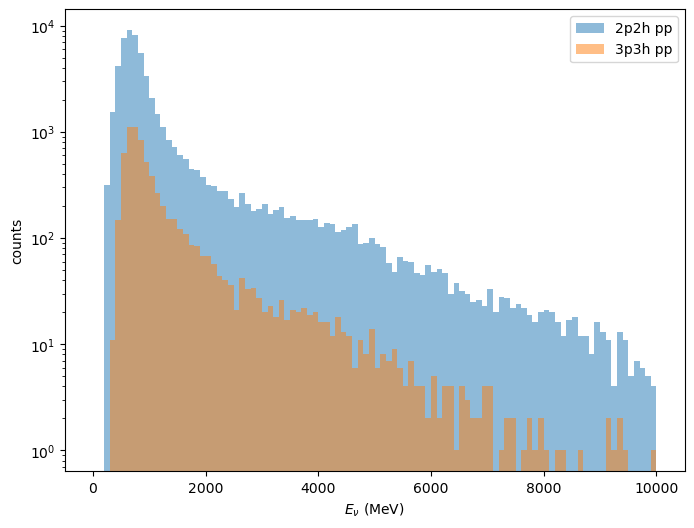

/tmp/ipykernel_336961/3917698416.py:96: RuntimeWarning: invalid value encountered in divide
  ratio = (n2p2h + n3p3h) / n2p2h


In [4]:
# prepare dataframes and reweight training

category = 'pp'
weight_channel = 'weight_pp'

# old Valencia inclusive as implemented in NEUT: (total entries: 10000000)
tree_neut = NuisanceFlatTree('/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/NEUT_output_files/NEUT:OldValencia_2p2h_t2kFlux_10k.root.GenericVectors.root',
        entry_start = 0, entry_stop = size)

# drop Enu > 10 GeV events for now
tree_neut.update_tree_with_mask(tree_neut._flattree_vars['Enu_true'] <= 10.0)

mask = tree_neut.get_mask_topology({'muon':'==1','proton':'==2','neutron':'==0'})
tree_neut.update_tree_with_mask(mask)

variable_exprs = ['leading_muon_px', 'leading_muon_py', 'leading_muon_pz',
                'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
                'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',
                'q0', 'q3', 'Q2', 'Enu_true']
oldInclusive[category] = create_dataframe_from_nuisance(tree_neut, variable_exprs=variable_exprs)
oldInclusive[category] = transform_momentum_to_reaction_frame(oldInclusive[category],                                                          
    selector_lepton='leading_muon', particle_names=['leading_proton', 'subleading_proton'])
# convert GeV to MeV
for key in variable_exprs:
    if key == 'Q2':
        oldInclusive[category][key] = oldInclusive[category][key] * 1e6
    else:
        oldInclusive[category][key] = oldInclusive[category][key] * 1e3
oldInclusive[category] = oldInclusive[category].rename(columns = {'Enu_true':'init_neutrino_E'})



# new Valencia inclusive, exclusive:
variables = {'muon_E':'leading_muon_E', 'muon_Px':'leading_muon_px', 'muon_Py':'leading_muon_py', 'muon_Pz':'leading_muon_pz', 'muon_P':'leading_muon_P', 
    'neutrino_E':'init_neutrino_E', 'neutrino_Px':'init_neutrino_px', 'neutrino_Py':'init_neutrino_py',
    'neutrino_Pz':'init_neutrino_pz', 'neutrino_P':'init_neutrino_P',
    'nucleon1_out_E':'leading_proton_E', 'nucleon1_out_Px':'leading_proton_px', 'nucleon1_out_Py':'leading_proton_py', 
    'nucleon1_out_Pz':'leading_proton_pz','nucleon1_out_P':'leading_proton_P',
    'nucleon2_out_E':'subleading_proton_E', 'nucleon2_out_Px':'subleading_proton_px', 'nucleon2_out_Py':'subleading_proton_py', 
    'nucleon2_out_Pz':'subleading_proton_pz','nucleon2_out_P':'subleading_proton_P', 
    'Q_E':'qtransfer_E', 'Q_Px':'qtransfer_px', 'Q_Py':'qtransfer_py', 'Q_Pz':'qtransfer_pz', 'Q_P':'qtransfer_P', weight_channel:weight_channel}

data_folder = '/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/PreFsi'

newInclusive[category] = uproot.open(f'{data_folder}/KinematicVariables_Enu=_T2K__Inclusive.root')['T'].arrays(library='pd',entry_start=0, entry_stop=size)[variables.keys()]
newExclusive[category] = uproot.open(f'{data_folder}/KinematicVariables_Enu=_T2K__Exclusive.root')['T'].arrays(library='pd',entry_start=size, entry_stop=size*2)[variables.keys()]

newInclusive[category] = newInclusive[category].loc[newInclusive[category][weight_channel]>=0]
newExclusive[category] = newExclusive[category].loc[newExclusive[category][weight_channel]>=0]

# drop Enu > 10 GeV for now
newInclusive[category] = newInclusive[category].loc[newInclusive[category]['neutrino_E'] <= 10000.0]
newExclusive[category] = newExclusive[category].loc[newExclusive[category]['neutrino_E'] <= 10000.0]

# relabel nucleon 1 and 2 to ensure nucleon1_out_E >= nucleon2_out_E 
mask = newInclusive[category]['nucleon1_out_E'] < newInclusive[category]['nucleon2_out_E']
newInclusive[category].loc[mask, ['nucleon1_out_E', 'nucleon2_out_E']] = newInclusive[category].loc[mask, ['nucleon2_out_E', 'nucleon1_out_E']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_P', 'nucleon2_out_P']] = newInclusive[category].loc[mask, ['nucleon2_out_P', 'nucleon1_out_P']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_Px', 'nucleon2_out_Px']] = newInclusive[category].loc[mask, ['nucleon2_out_Px', 'nucleon1_out_Px']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_Py', 'nucleon2_out_Py']] = newInclusive[category].loc[mask, ['nucleon2_out_Py', 'nucleon1_out_Py']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_Pz', 'nucleon2_out_Pz']] = newInclusive[category].loc[mask, ['nucleon2_out_Pz', 'nucleon1_out_Pz']].to_numpy()

mask = newExclusive[category]['nucleon1_out_E'] < newExclusive[category]['nucleon2_out_E']
newExclusive[category].loc[mask, ['nucleon1_out_E', 'nucleon2_out_E']] = newExclusive[category].loc[mask, ['nucleon2_out_E', 'nucleon1_out_E']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_P', 'nucleon2_out_P']] = newExclusive[category].loc[mask, ['nucleon2_out_P', 'nucleon1_out_P']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_Px', 'nucleon2_out_Px']] = newExclusive[category].loc[mask, ['nucleon2_out_Px', 'nucleon1_out_Px']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_Py', 'nucleon2_out_Py']] = newExclusive[category].loc[mask, ['nucleon2_out_Py', 'nucleon1_out_Py']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_Pz', 'nucleon2_out_Pz']] = newExclusive[category].loc[mask, ['nucleon2_out_Pz', 'nucleon1_out_Pz']].to_numpy()



newInclusive[category] = newInclusive[category].rename(columns = variables)
newExclusive[category] = newExclusive[category].rename(columns = variables)

newInclusive[category] = transform_momentum_to_reaction_frame(newInclusive[category], selector_lepton='leading_muon',particle_names=['leading_proton','subleading_proton','qtransfer'])
newExclusive[category] = transform_momentum_to_reaction_frame(newExclusive[category], selector_lepton='leading_muon',particle_names=['leading_proton','subleading_proton','qtransfer'])
# for df in [source_train, source_test, target_train, target_test]:
for df in [newInclusive[category], newExclusive[category]]:
    df['q0'] = df['qtransfer_E']
    df['q3'] = df['qtransfer_P']
    df['Q2'] = df['q3']**2 - df['q0']**2



# Scale up 2p2h strength by 3p3h contribution
Enu_max = max(oldInclusive[category]['init_neutrino_E'].max(), oldInclusive3p3h[category ]['init_neutrino_E'].max())
bins = np.arange(0,Enu_max+100, 100)
plt.figure(figsize=(8,6))
n2p2h, _, _ = plt.hist(oldInclusive[category]['init_neutrino_E'], bins=bins, label=f'2p2h {category}', alpha=0.5)
n3p3h, _, _ = plt.hist(oldInclusive3p3h[category ]['init_neutrino_E'], bins=bins, label=f'3p3h {category}', alpha=0.5)
plt.legend()
plt.yscale('log')
plt.xlabel('$E_\\nu$ (MeV)')
plt.ylabel('counts')
plt.show()
ratio = (n2p2h + n3p3h) / n2p2h
ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)
nthbin = np.searchsorted(bins, oldInclusive[category]['init_neutrino_E'], side="right") - 1

# customize an original weight for old valencia
oldInclusive[category]['weight0'] = np.ones(len(oldInclusive[category])) * np.sum(newInclusive[category][weight_channel]) / len(oldInclusive[category])
oldInclusive[category]['weight0'] = oldInclusive[category]['weight0'] * ratio[nthbin]





# reweight to new inclusive first:
# train reweighter
reweight_variables = [
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    # 'init_neutrino_E'
]

reweighter = Reweighter(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, gb_args={'subsample': 1.0})
reweighter.fit(oldInclusive[category][reweight_variables], newInclusive[category][reweight_variables],
            original_weight=oldInclusive[category]['weight0'],
            target_weight=newInclusive[category][weight_channel]
)
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_oldInclusive_to_newInclusive_{category}.pkl')
# # load from saved:
# reweighter = Reweighter.load_from_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_oldInclusive_to_newInclusive_{category}.pkl')



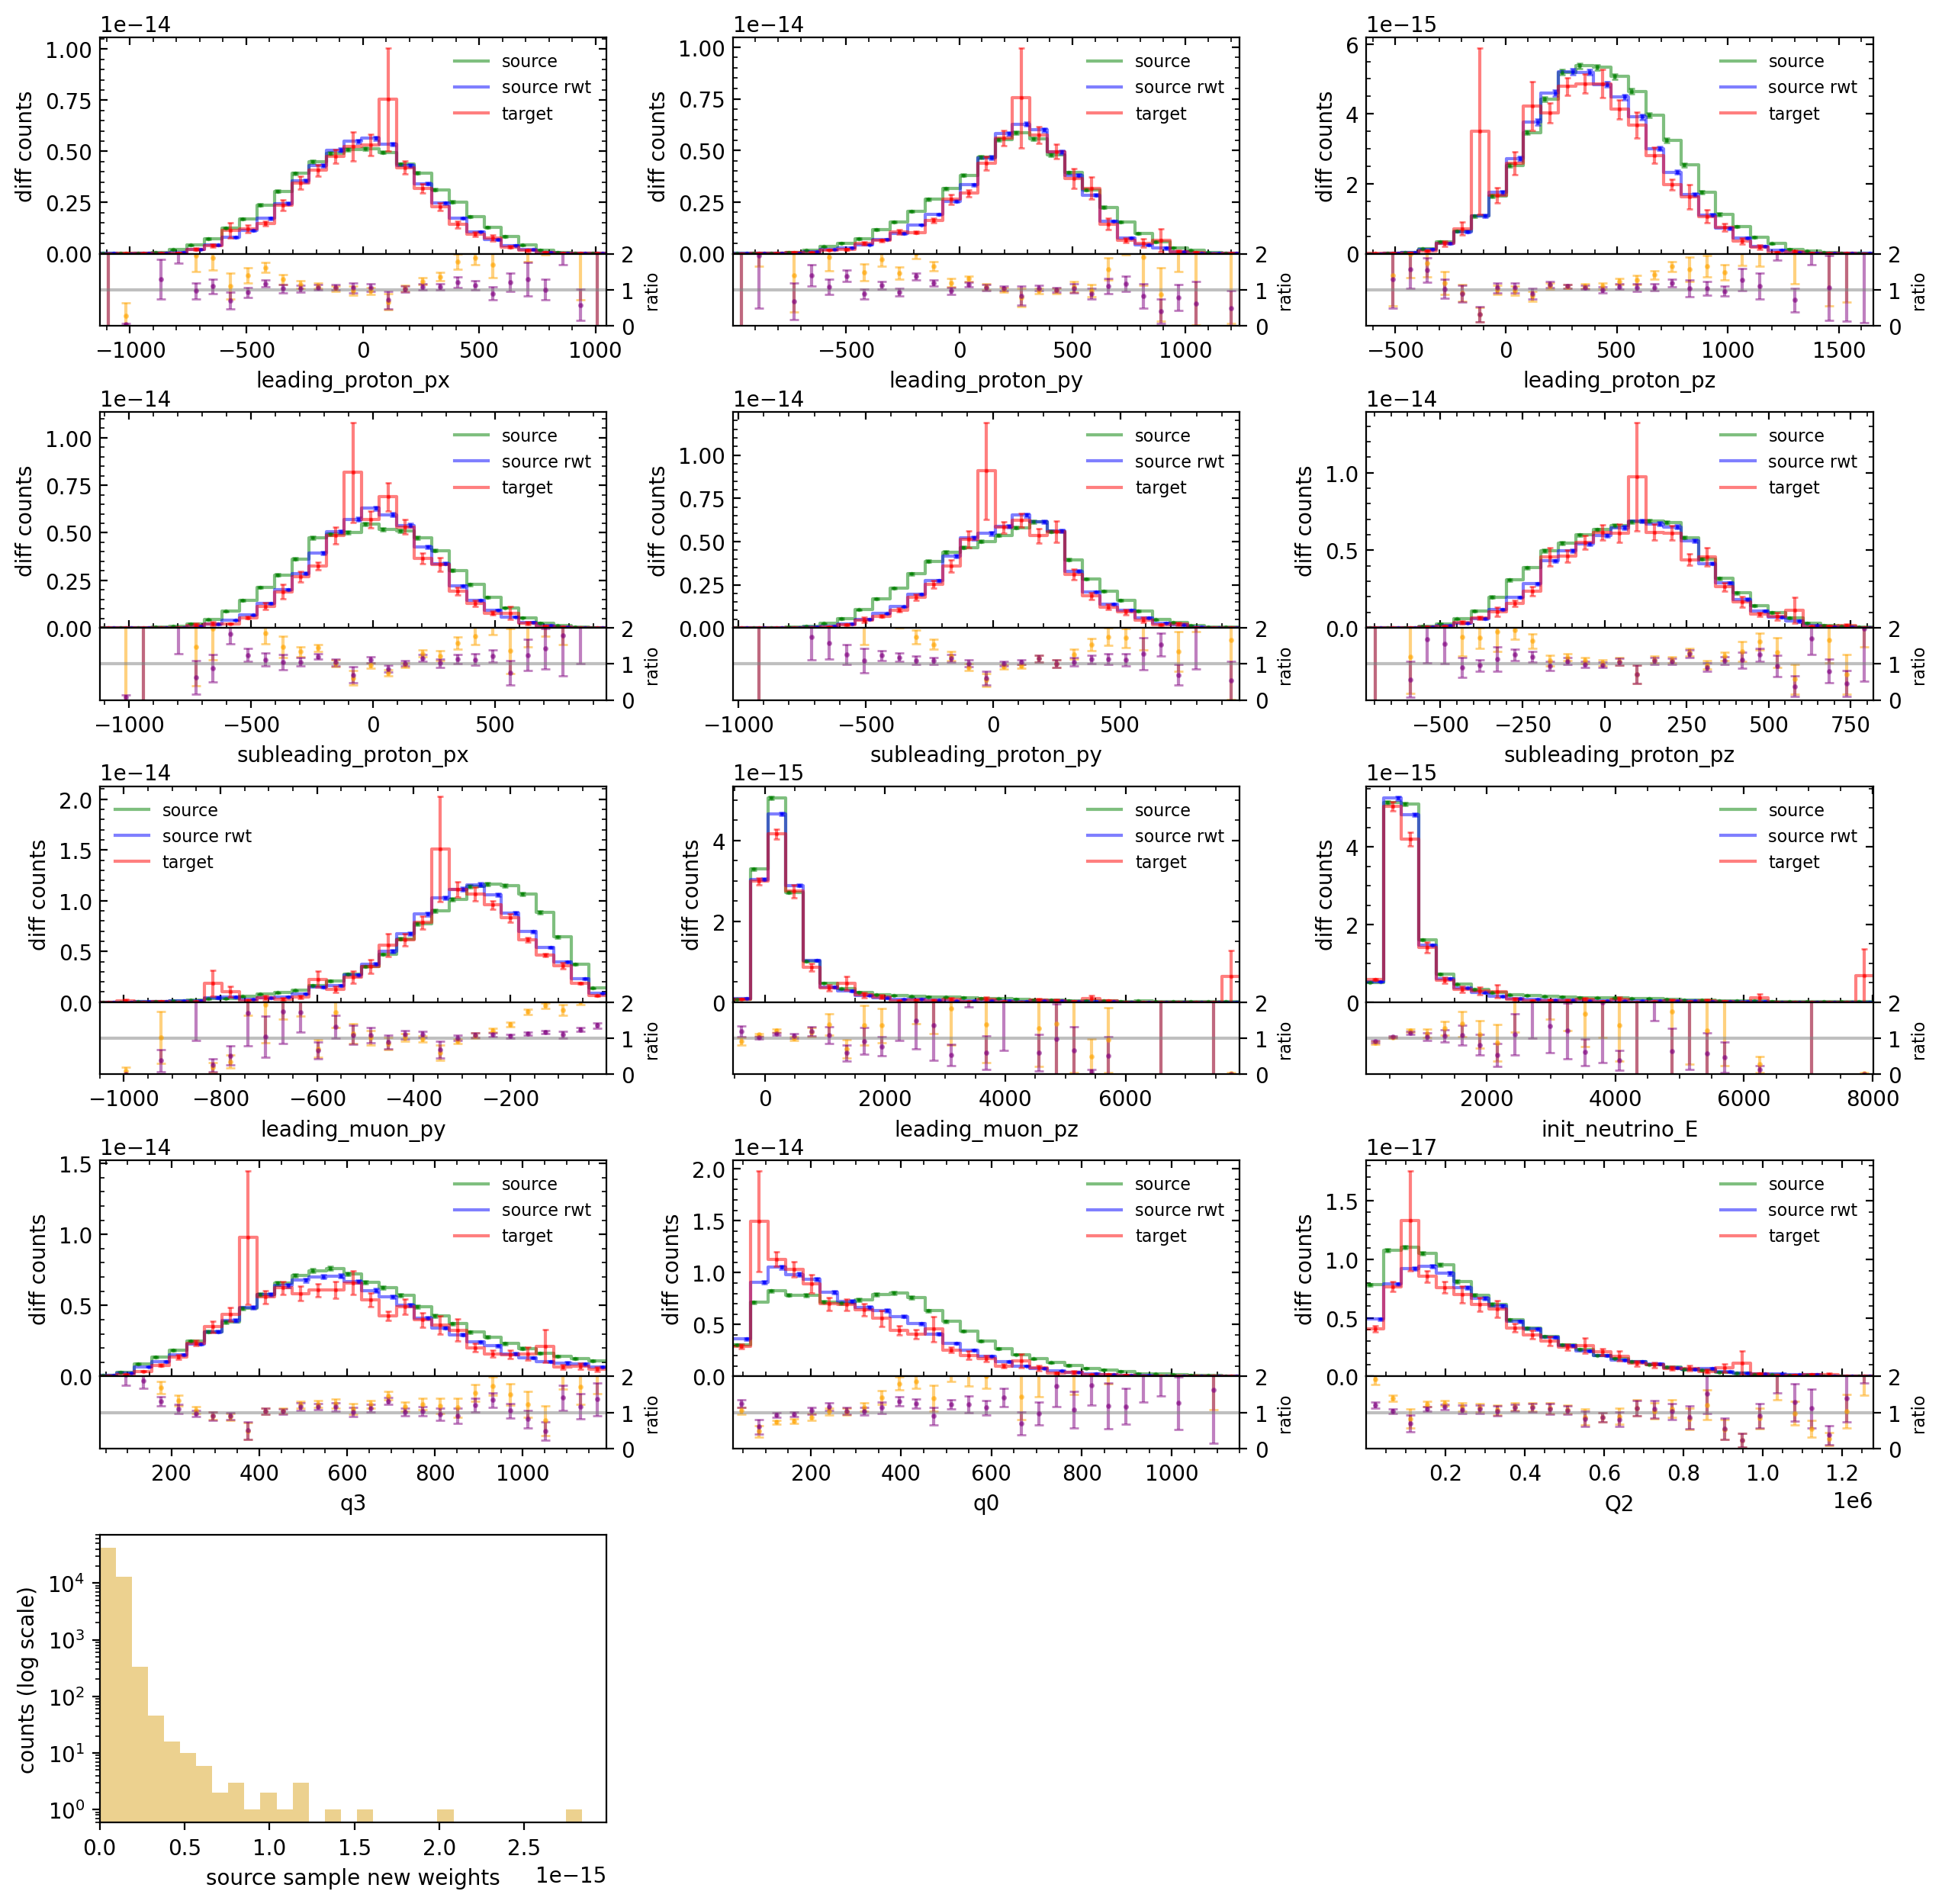

In [5]:
# predict weights and plot
oldInclusive[category]['weight1'] = reweighter.predict_matched_total_weights(oldInclusive[category][reweight_variables], 
            original_weight=oldInclusive[category]['weight0'],
            target_weight=newInclusive[category][weight_channel]
)
oldInclusive[category]['weight'] = oldInclusive[category]['weight1']

drawing_variables=[
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    'init_neutrino_E',
    'q3', 'q0','Q2',
    'weight',
]

mask = oldInclusive[category]['weight1']>=0
draw_source_target_distributions_and_ratio(oldInclusive[category].loc[mask], newInclusive[category], variables=drawing_variables,
    source_weights=oldInclusive[category].loc[mask]['weight0'], 
    new_source_weights=oldInclusive[category].loc[mask]['weight1'], 
    target_weights=newInclusive[category][weight_channel]
)

### 2p2h pn channel:

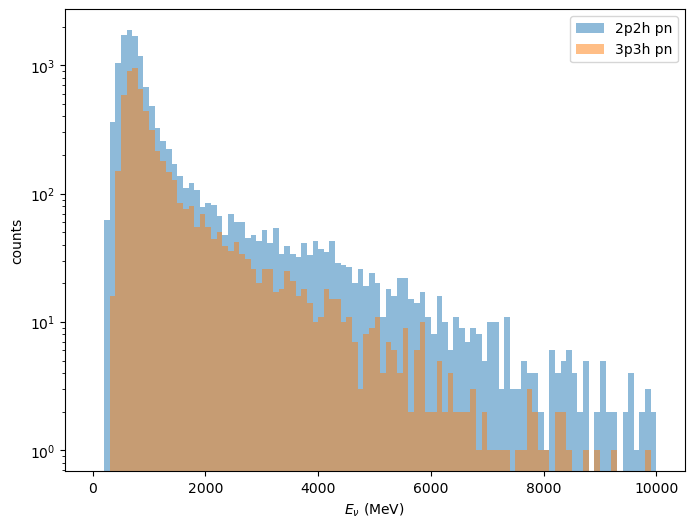

/tmp/ipykernel_336961/3869239747.py:102: RuntimeWarning: invalid value encountered in divide
  ratio = (n2p2h + n3p3h) / n2p2h


In [6]:
# prepare dataframes and reweight training

category = 'pn'
weight_channel = 'weight_pn'

# old Valencia inclusive as implemented in NEUT:
tree_neut = NuisanceFlatTree('/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/NEUT_output_files/NEUT:OldValencia_2p2h_t2kFlux_10k.root.GenericVectors.root',
        entry_start = 0, entry_stop = size)

# drop Enu > 10 GeV events for now
tree_neut.update_tree_with_mask(tree_neut._flattree_vars['Enu_true'] <= 10.0)

mask = tree_neut.get_mask_topology({'muon':'==1','proton':'==1','neutron':'==1'})
tree_neut.update_tree_with_mask(mask)
# select out those with proton KE >= neutron KE (i.e., pn final state events)
mask = (tree_neut.get_event_variable('leading_proton_KE') - tree_neut.get_event_variable('leading_neutron_KE')) >=0
tree_neut.update_tree_with_mask(mask)



variable_exprs = ['leading_muon_px', 'leading_muon_py', 'leading_muon_pz',
                'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
                'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
                'q0', 'q3', 'Q2', 'Enu_true']
oldInclusive[category] = create_dataframe_from_nuisance(tree_neut, variable_exprs=variable_exprs)
oldInclusive[category] = transform_momentum_to_reaction_frame(oldInclusive[category],                                                          
    selector_lepton='leading_muon', particle_names=['leading_proton', 'leading_neutron'])
# convert GeV to MeV
for key in variable_exprs:
    if key == 'Q2':
        oldInclusive[category][key] = oldInclusive[category][key] * 1e6
    else:
        oldInclusive[category][key] = oldInclusive[category][key] * 1e3
oldInclusive[category] = oldInclusive[category].rename(columns = {'Enu_true':'init_neutrino_E'})




# new Valencia inclusive, exclusive:
variables = {'muon_E':'leading_muon_E', 'muon_Px':'leading_muon_px', 'muon_Py':'leading_muon_py', 'muon_Pz':'leading_muon_pz', 'muon_P':'leading_muon_P', 
    'neutrino_E':'init_neutrino_E', 'neutrino_Px':'init_neutrino_px', 'neutrino_Py':'init_neutrino_py',
    'neutrino_Pz':'init_neutrino_pz', 'neutrino_P':'init_neutrino_P',
    'nucleon1_out_E':'leading_proton_E', 'nucleon1_out_Px':'leading_proton_px', 'nucleon1_out_Py':'leading_proton_py', 
    'nucleon1_out_Pz':'leading_proton_pz','nucleon1_out_P':'leading_proton_P',
    'nucleon2_out_E':'leading_neutron_E', 'nucleon2_out_Px':'leading_neutron_px', 'nucleon2_out_Py':'leading_neutron_py', 
    'nucleon2_out_Pz':'leading_neutron_pz','nucleon2_out_P':'leading_neutron_P', 
    'Q_E':'qtransfer_E', 'Q_Px':'qtransfer_px', 'Q_Py':'qtransfer_py', 'Q_Pz':'qtransfer_pz', 'Q_P':'qtransfer_P', weight_channel:weight_channel}

data_folder = '/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/PreFsi'

newInclusive[category] = uproot.open(f'{data_folder}/KinematicVariables_Enu=_T2K__Inclusive.root')['T'].arrays(library='pd',entry_start=0, entry_stop=size)[variables.keys()]
newExclusive[category] = uproot.open(f'{data_folder}/KinematicVariables_Enu=_T2K__Exclusive.root')['T'].arrays(library='pd',entry_start=size, entry_stop=size*2)[variables.keys()]

newInclusive[category] = newInclusive[category].loc[newInclusive[category][weight_channel]>=0]
newExclusive[category] = newExclusive[category].loc[newExclusive[category][weight_channel]>=0]

# drop Enu > 10 GeV for now
newInclusive[category] = newInclusive[category].loc[newInclusive[category]['neutrino_E'] <= 10000.0]
newExclusive[category] = newExclusive[category].loc[newExclusive[category]['neutrino_E'] <= 10000.0]

# relabel nucleon 1 and 2 to ensure nucleon1_out_E >= nucleon2_out_E 
mask = newInclusive[category]['nucleon1_out_E'] < newInclusive[category]['nucleon2_out_E']
newInclusive[category].loc[mask, ['nucleon1_out_E', 'nucleon2_out_E']] = newInclusive[category].loc[mask, ['nucleon2_out_E', 'nucleon1_out_E']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_P', 'nucleon2_out_P']] = newInclusive[category].loc[mask, ['nucleon2_out_P', 'nucleon1_out_P']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_Px', 'nucleon2_out_Px']] = newInclusive[category].loc[mask, ['nucleon2_out_Px', 'nucleon1_out_Px']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_Py', 'nucleon2_out_Py']] = newInclusive[category].loc[mask, ['nucleon2_out_Py', 'nucleon1_out_Py']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_Pz', 'nucleon2_out_Pz']] = newInclusive[category].loc[mask, ['nucleon2_out_Pz', 'nucleon1_out_Pz']].to_numpy()

mask = newExclusive[category]['nucleon1_out_E'] < newExclusive[category]['nucleon2_out_E']
newExclusive[category].loc[mask, ['nucleon1_out_E', 'nucleon2_out_E']] = newExclusive[category].loc[mask, ['nucleon2_out_E', 'nucleon1_out_E']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_P', 'nucleon2_out_P']] = newExclusive[category].loc[mask, ['nucleon2_out_P', 'nucleon1_out_P']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_Px', 'nucleon2_out_Px']] = newExclusive[category].loc[mask, ['nucleon2_out_Px', 'nucleon1_out_Px']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_Py', 'nucleon2_out_Py']] = newExclusive[category].loc[mask, ['nucleon2_out_Py', 'nucleon1_out_Py']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_Pz', 'nucleon2_out_Pz']] = newExclusive[category].loc[mask, ['nucleon2_out_Pz', 'nucleon1_out_Pz']].to_numpy()


newInclusive[category] = newInclusive[category].rename(columns = variables)
newExclusive[category] = newExclusive[category].rename(columns = variables)

newInclusive[category] = transform_momentum_to_reaction_frame(newInclusive[category], selector_lepton='leading_muon',particle_names=['leading_proton','leading_neutron','qtransfer'])
newExclusive[category] = transform_momentum_to_reaction_frame(newExclusive[category], selector_lepton='leading_muon',particle_names=['leading_proton','leading_neutron','qtransfer'])
# for df in [source_train, source_test, target_train, target_test]:
for df in [newInclusive[category], newExclusive[category]]:
    df['q0'] = df['qtransfer_E']
    df['q3'] = df['qtransfer_P']
    df['Q2'] = df['q3']**2 - df['q0']**2




# Scale up 2p2h strength by 3p3h contribution
Enu_max = max(oldInclusive[category]['init_neutrino_E'].max(), oldInclusive3p3h[category ]['init_neutrino_E'].max())
bins = np.arange(0,Enu_max+100, 100)
plt.figure(figsize=(8,6))
n2p2h, _, _ = plt.hist(oldInclusive[category]['init_neutrino_E'], bins=bins, label=f'2p2h {category}', alpha=0.5)
n3p3h, _, _ = plt.hist(oldInclusive3p3h[category ]['init_neutrino_E'], bins=bins, label=f'3p3h {category}', alpha=0.5)
plt.legend()
plt.yscale('log')
plt.xlabel('$E_\\nu$ (MeV)')
plt.ylabel('counts')
plt.show()
ratio = (n2p2h + n3p3h) / n2p2h
ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)
nthbin = np.searchsorted(bins, oldInclusive[category]['init_neutrino_E'], side="right") - 1

# customize an original weight for old valencia
oldInclusive[category]['weight0'] = np.ones(len(oldInclusive[category])) * np.sum(newInclusive[category][weight_channel]) / len(oldInclusive[category])
oldInclusive[category]['weight0'] = oldInclusive[category]['weight0'] * ratio[nthbin]







# reweight to new inclusive first:
# train reweighter
reweight_variables = [
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_muon_py', 'leading_muon_pz',
    # 'init_neutrino_E'
]

reweighter = Reweighter(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, gb_args={'subsample': 1.0})
reweighter.fit(oldInclusive[category][reweight_variables], newInclusive[category][reweight_variables],
            original_weight=oldInclusive[category]['weight0'],
            target_weight=newInclusive[category][weight_channel]
)
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_oldInclusive_to_newInclusive_{category}.pkl')

# # load from saved
# reweighter = Reweighter.load_from_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_oldInclusive_to_newInclusive_{category}.pkl')



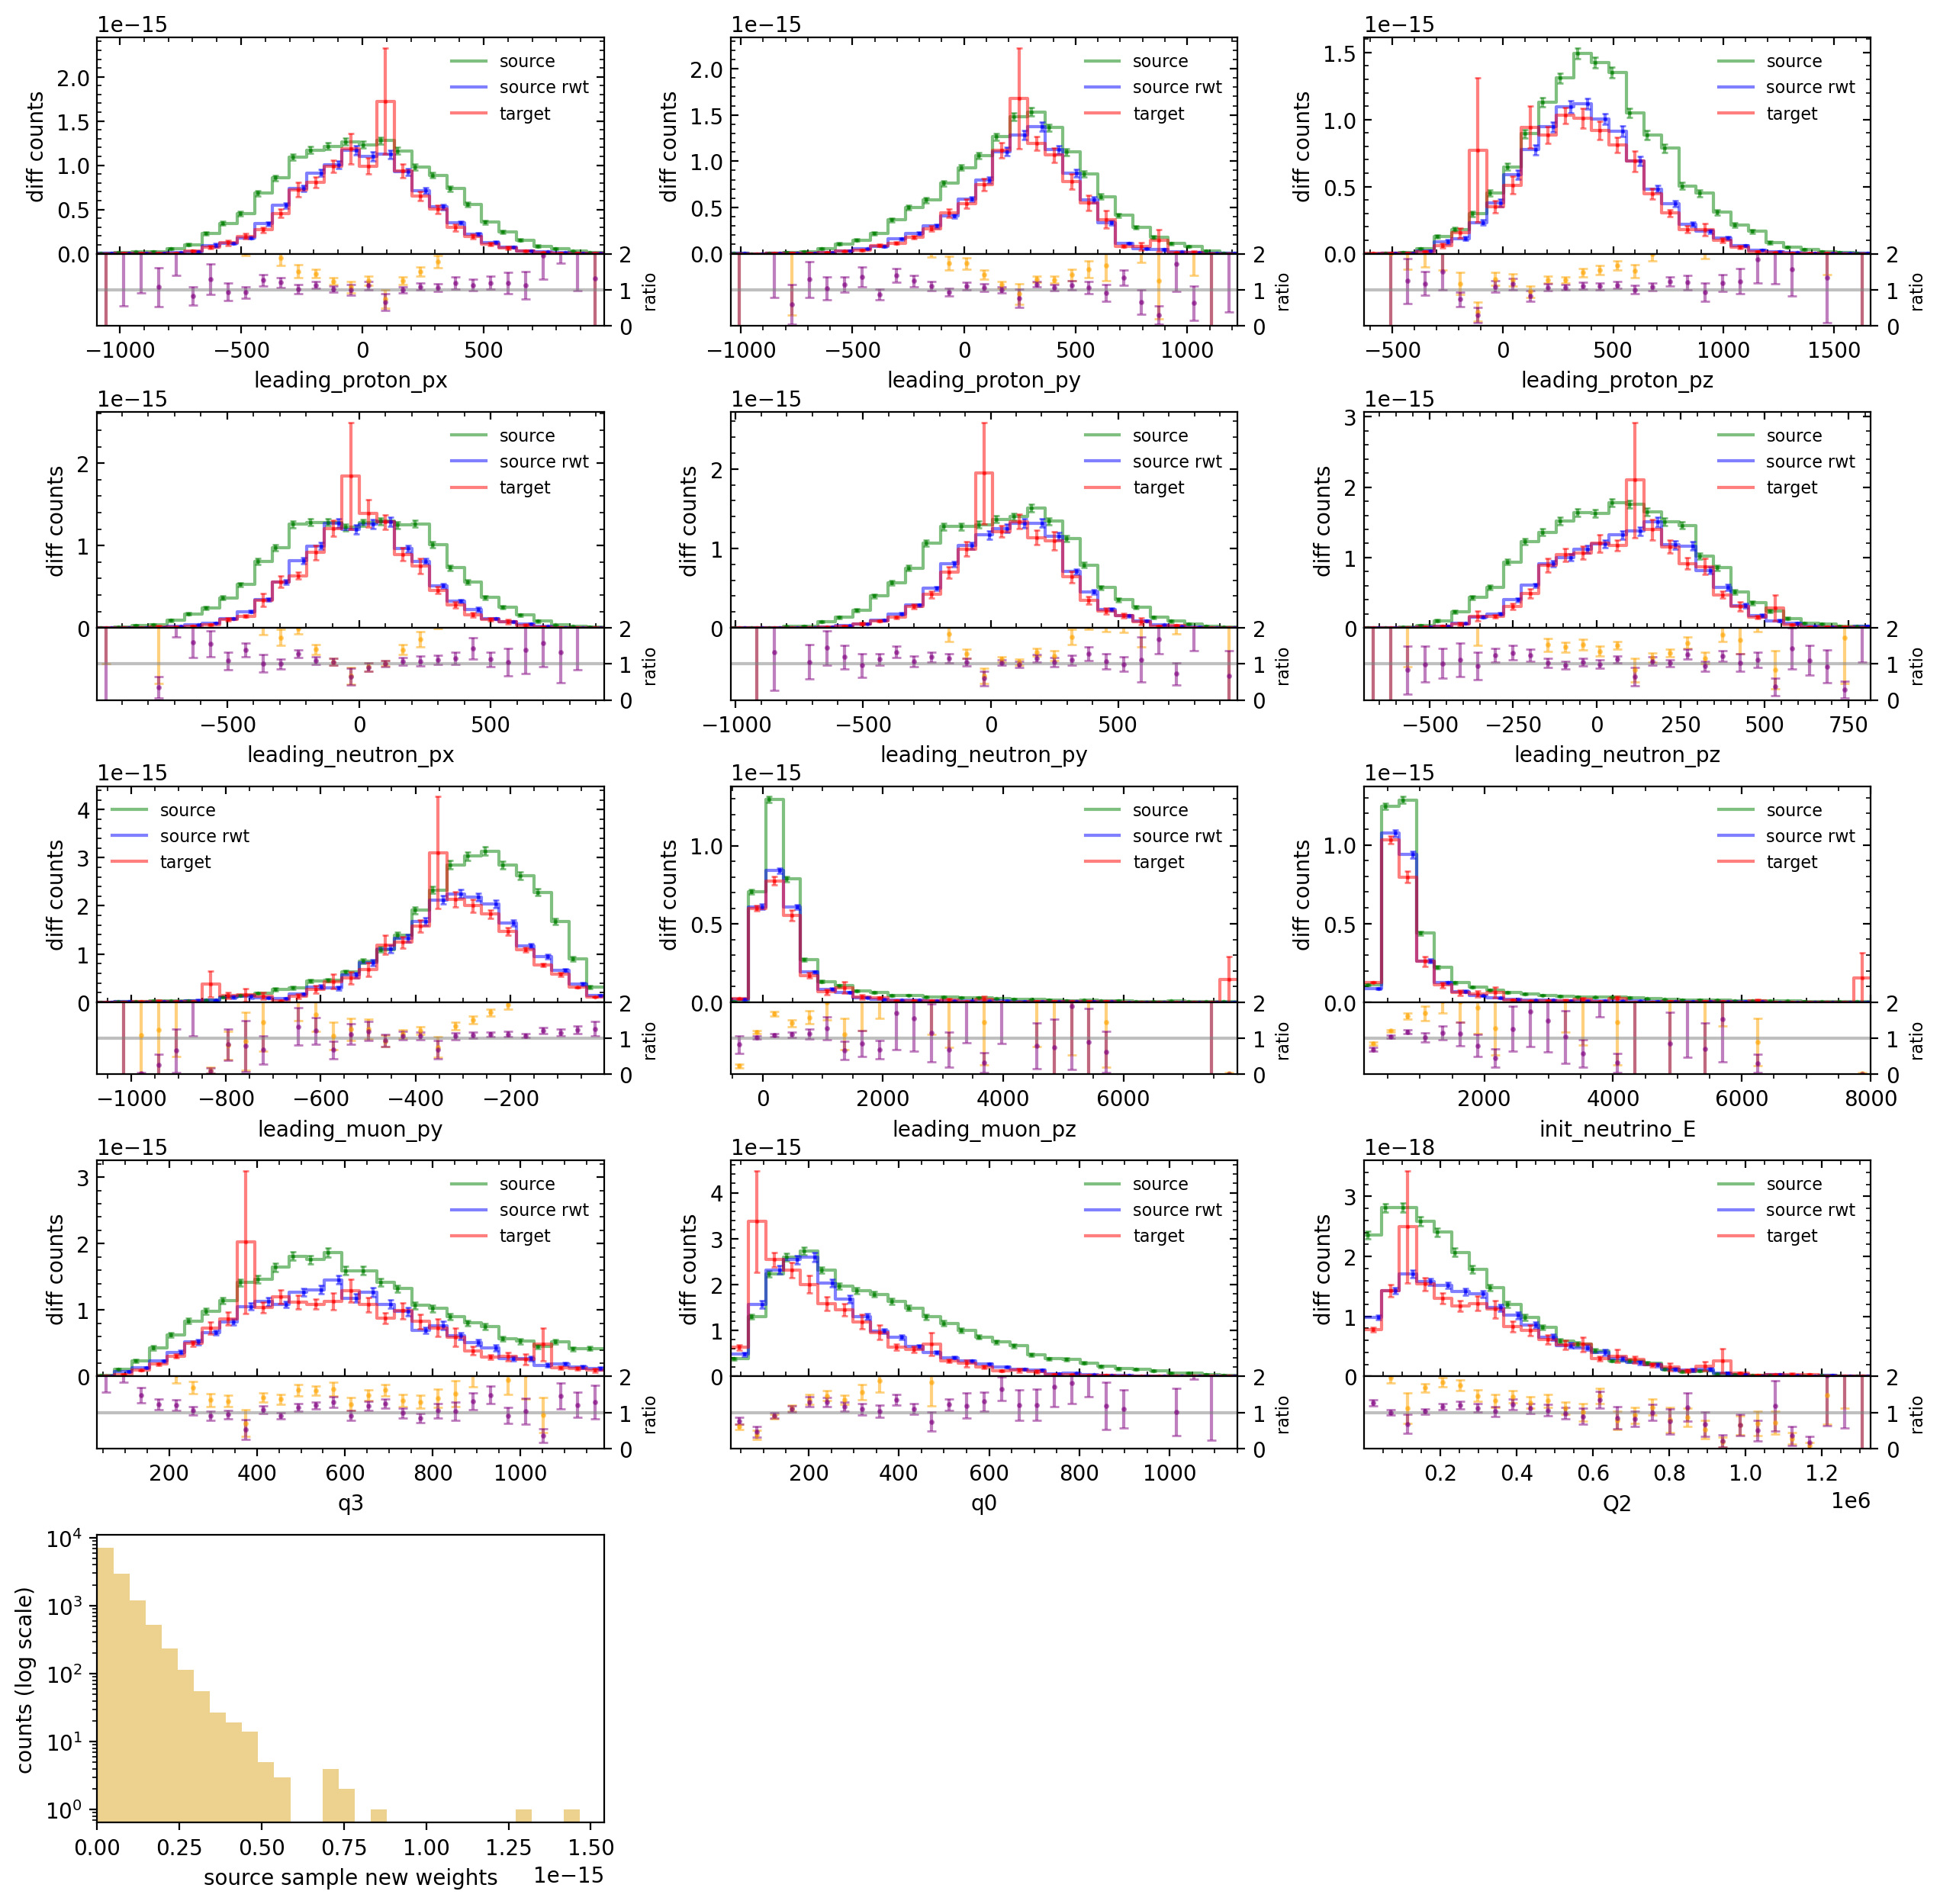

In [7]:
# predict weights and plot
oldInclusive[category]['weight1'] = reweighter.predict_matched_total_weights(oldInclusive[category][reweight_variables], 
            original_weight=oldInclusive[category]['weight0'],
            target_weight=newInclusive[category][weight_channel]
)
oldInclusive[category]['weight'] = oldInclusive[category]['weight1']

drawing_variables=[
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_muon_py', 'leading_muon_pz',
    'init_neutrino_E',
    'q3', 'q0','Q2',
    'weight',
]

mask = oldInclusive[category]['weight1']>=0
draw_source_target_distributions_and_ratio(oldInclusive[category].loc[mask], newInclusive[category], variables=drawing_variables,
    source_weights=oldInclusive[category].loc[mask]['weight0'], 
    new_source_weights=oldInclusive[category].loc[mask]['weight1'], 
    target_weights=newInclusive[category][weight_channel]
)

### 2p2h np channel:

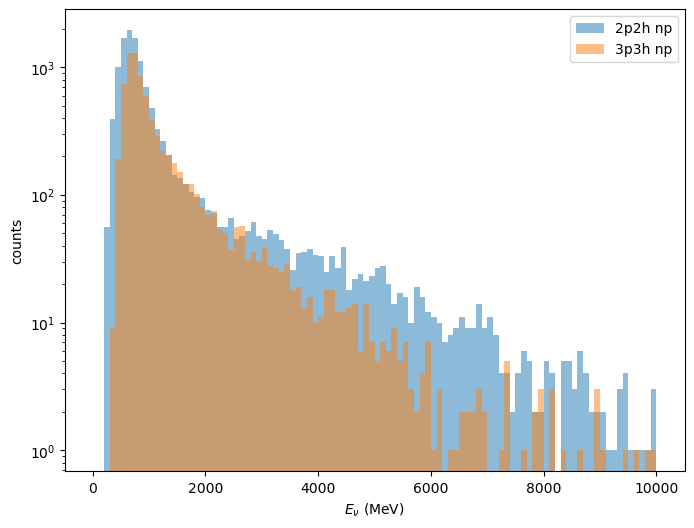

/tmp/ipykernel_336961/3640797581.py:102: RuntimeWarning: invalid value encountered in divide
  ratio = (n2p2h + n3p3h) / n2p2h


In [8]:
# prepare dataframes and reweight training

category = 'np'
weight_channel = 'weight_np'

# old Valencia inclusive as implemented in NEUT:
tree_neut = NuisanceFlatTree('/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/NEUT_output_files/NEUT:OldValencia_2p2h_t2kFlux_10k.root.GenericVectors.root',
        entry_start = 0, entry_stop = size)

# drop Enu > 10 GeV events for now
tree_neut.update_tree_with_mask(tree_neut._flattree_vars['Enu_true'] <= 10.0)

mask = tree_neut.get_mask_topology({'muon':'==1','proton':'==1','neutron':'==1'})
tree_neut.update_tree_with_mask(mask)
# select out those with proton KE < neutron KE (i.e., np final state events)
mask = (tree_neut.get_event_variable('leading_proton_KE') - tree_neut.get_event_variable('leading_neutron_KE')) < 0
tree_neut.update_tree_with_mask(mask)



variable_exprs = ['leading_muon_px', 'leading_muon_py', 'leading_muon_pz',
                'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
                'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
                'q0', 'q3', 'Q2', 'Enu_true']
oldInclusive[category] = create_dataframe_from_nuisance(tree_neut, variable_exprs=variable_exprs)
oldInclusive[category] = transform_momentum_to_reaction_frame(oldInclusive[category],                                                          
    selector_lepton='leading_muon', particle_names=['leading_proton', 'leading_neutron'])
# convert GeV to MeV
for key in variable_exprs:
    if key == 'Q2':
        oldInclusive[category][key] = oldInclusive[category][key] * 1e6
    else:
        oldInclusive[category][key] = oldInclusive[category][key] * 1e3
oldInclusive[category] = oldInclusive[category].rename(columns = {'Enu_true':'init_neutrino_E'})




# new Valencia inclusive, exclusive:
variables = {'muon_E':'leading_muon_E', 'muon_Px':'leading_muon_px', 'muon_Py':'leading_muon_py', 'muon_Pz':'leading_muon_pz', 'muon_P':'leading_muon_P', 
    'neutrino_E':'init_neutrino_E', 'neutrino_Px':'init_neutrino_px', 'neutrino_Py':'init_neutrino_py',
    'neutrino_Pz':'init_neutrino_pz', 'neutrino_P':'init_neutrino_P',
    'nucleon1_out_E':'leading_neutron_E', 'nucleon1_out_Px':'leading_neutron_px', 'nucleon1_out_Py':'leading_neutron_py', 
    'nucleon1_out_Pz':'leading_neutron_pz','nucleon1_out_P':'leading_neutron_P', 
    'nucleon2_out_E':'leading_proton_E', 'nucleon2_out_Px':'leading_proton_px', 'nucleon2_out_Py':'leading_proton_py', 
    'nucleon2_out_Pz':'leading_proton_pz','nucleon2_out_P':'leading_proton_P',
    'Q_E':'qtransfer_E', 'Q_Px':'qtransfer_px', 'Q_Py':'qtransfer_py', 'Q_Pz':'qtransfer_pz', 'Q_P':'qtransfer_P', weight_channel:weight_channel}

data_folder = '/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/PreFsi'

newInclusive[category] = uproot.open(f'{data_folder}/KinematicVariables_Enu=_T2K__Inclusive.root')['T'].arrays(library='pd',entry_start=0, entry_stop=size)[variables.keys()]
newExclusive[category] = uproot.open(f'{data_folder}/KinematicVariables_Enu=_T2K__Exclusive.root')['T'].arrays(library='pd',entry_start=size, entry_stop=size*2)[variables.keys()]

newInclusive[category] = newInclusive[category].loc[newInclusive[category][weight_channel]>=0]
newExclusive[category] = newExclusive[category].loc[newExclusive[category][weight_channel]>=0]

# drop Enu > 10 GeV for now
newInclusive[category] = newInclusive[category].loc[newInclusive[category]['neutrino_E'] <= 10000.0]
newExclusive[category] = newExclusive[category].loc[newExclusive[category]['neutrino_E'] <= 10000.0]

# relabel nucleon 1 and 2 to ensure nucleon1_out_E >= nucleon2_out_E 
mask = newInclusive[category]['nucleon1_out_E'] < newInclusive[category]['nucleon2_out_E']
newInclusive[category].loc[mask, ['nucleon1_out_E', 'nucleon2_out_E']] = newInclusive[category].loc[mask, ['nucleon2_out_E', 'nucleon1_out_E']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_P', 'nucleon2_out_P']] = newInclusive[category].loc[mask, ['nucleon2_out_P', 'nucleon1_out_P']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_Px', 'nucleon2_out_Px']] = newInclusive[category].loc[mask, ['nucleon2_out_Px', 'nucleon1_out_Px']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_Py', 'nucleon2_out_Py']] = newInclusive[category].loc[mask, ['nucleon2_out_Py', 'nucleon1_out_Py']].to_numpy()
newInclusive[category].loc[mask, ['nucleon1_out_Pz', 'nucleon2_out_Pz']] = newInclusive[category].loc[mask, ['nucleon2_out_Pz', 'nucleon1_out_Pz']].to_numpy()

mask = newExclusive[category]['nucleon1_out_E'] < newExclusive[category]['nucleon2_out_E']
newExclusive[category].loc[mask, ['nucleon1_out_E', 'nucleon2_out_E']] = newExclusive[category].loc[mask, ['nucleon2_out_E', 'nucleon1_out_E']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_P', 'nucleon2_out_P']] = newExclusive[category].loc[mask, ['nucleon2_out_P', 'nucleon1_out_P']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_Px', 'nucleon2_out_Px']] = newExclusive[category].loc[mask, ['nucleon2_out_Px', 'nucleon1_out_Px']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_Py', 'nucleon2_out_Py']] = newExclusive[category].loc[mask, ['nucleon2_out_Py', 'nucleon1_out_Py']].to_numpy()
newExclusive[category].loc[mask, ['nucleon1_out_Pz', 'nucleon2_out_Pz']] = newExclusive[category].loc[mask, ['nucleon2_out_Pz', 'nucleon1_out_Pz']].to_numpy()


newInclusive[category] = newInclusive[category].rename(columns = variables)
newExclusive[category] = newExclusive[category].rename(columns = variables)

newInclusive[category] = transform_momentum_to_reaction_frame(newInclusive[category], selector_lepton='leading_muon',particle_names=['leading_proton','leading_neutron','qtransfer'])
newExclusive[category] = transform_momentum_to_reaction_frame(newExclusive[category], selector_lepton='leading_muon',particle_names=['leading_proton','leading_neutron','qtransfer'])
# for df in [source_train, source_test, target_train, target_test]:
for df in [newInclusive[category], newExclusive[category]]:
    df['q0'] = df['qtransfer_E']
    df['q3'] = df['qtransfer_P']
    df['Q2'] = df['q3']**2 - df['q0']**2




# Scale up 2p2h strength by 3p3h contribution
Enu_max = max(oldInclusive[category]['init_neutrino_E'].max(), oldInclusive3p3h[category ]['init_neutrino_E'].max())
bins = np.arange(0,Enu_max+100, 100)
plt.figure(figsize=(8,6))
n2p2h, _, _ = plt.hist(oldInclusive[category]['init_neutrino_E'], bins=bins, label=f'2p2h {category}', alpha=0.5)
n3p3h, _, _ = plt.hist(oldInclusive3p3h[category ]['init_neutrino_E'], bins=bins, label=f'3p3h {category}', alpha=0.5)
plt.legend()
plt.yscale('log')
plt.xlabel('$E_\\nu$ (MeV)')
plt.ylabel('counts')
plt.show()
ratio = (n2p2h + n3p3h) / n2p2h
ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)
nthbin = np.searchsorted(bins, oldInclusive[category]['init_neutrino_E'], side="right") - 1

# customize an original weight for old valencia
oldInclusive[category]['weight0'] = np.ones(len(oldInclusive[category])) * np.sum(newInclusive[category][weight_channel]) / len(oldInclusive[category])
oldInclusive[category]['weight0'] = oldInclusive[category]['weight0'] * ratio[nthbin]




# reweight to new inclusive first:
# train reweighter
reweight_variables = [
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    # 'init_neutrino_E'
]

reweighter = Reweighter(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, gb_args={'subsample': 1.0})
reweighter.fit(oldInclusive[category][reweight_variables], newInclusive[category][reweight_variables],
            original_weight=oldInclusive[category]['weight0'],
            target_weight=newInclusive[category][weight_channel]
)
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_oldInclusive_to_newInclusive_{category}.pkl')

# # load from saved
# reweighter = Reweighter.load_from_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_oldInclusive_to_newInclusive_{category}.pkl')



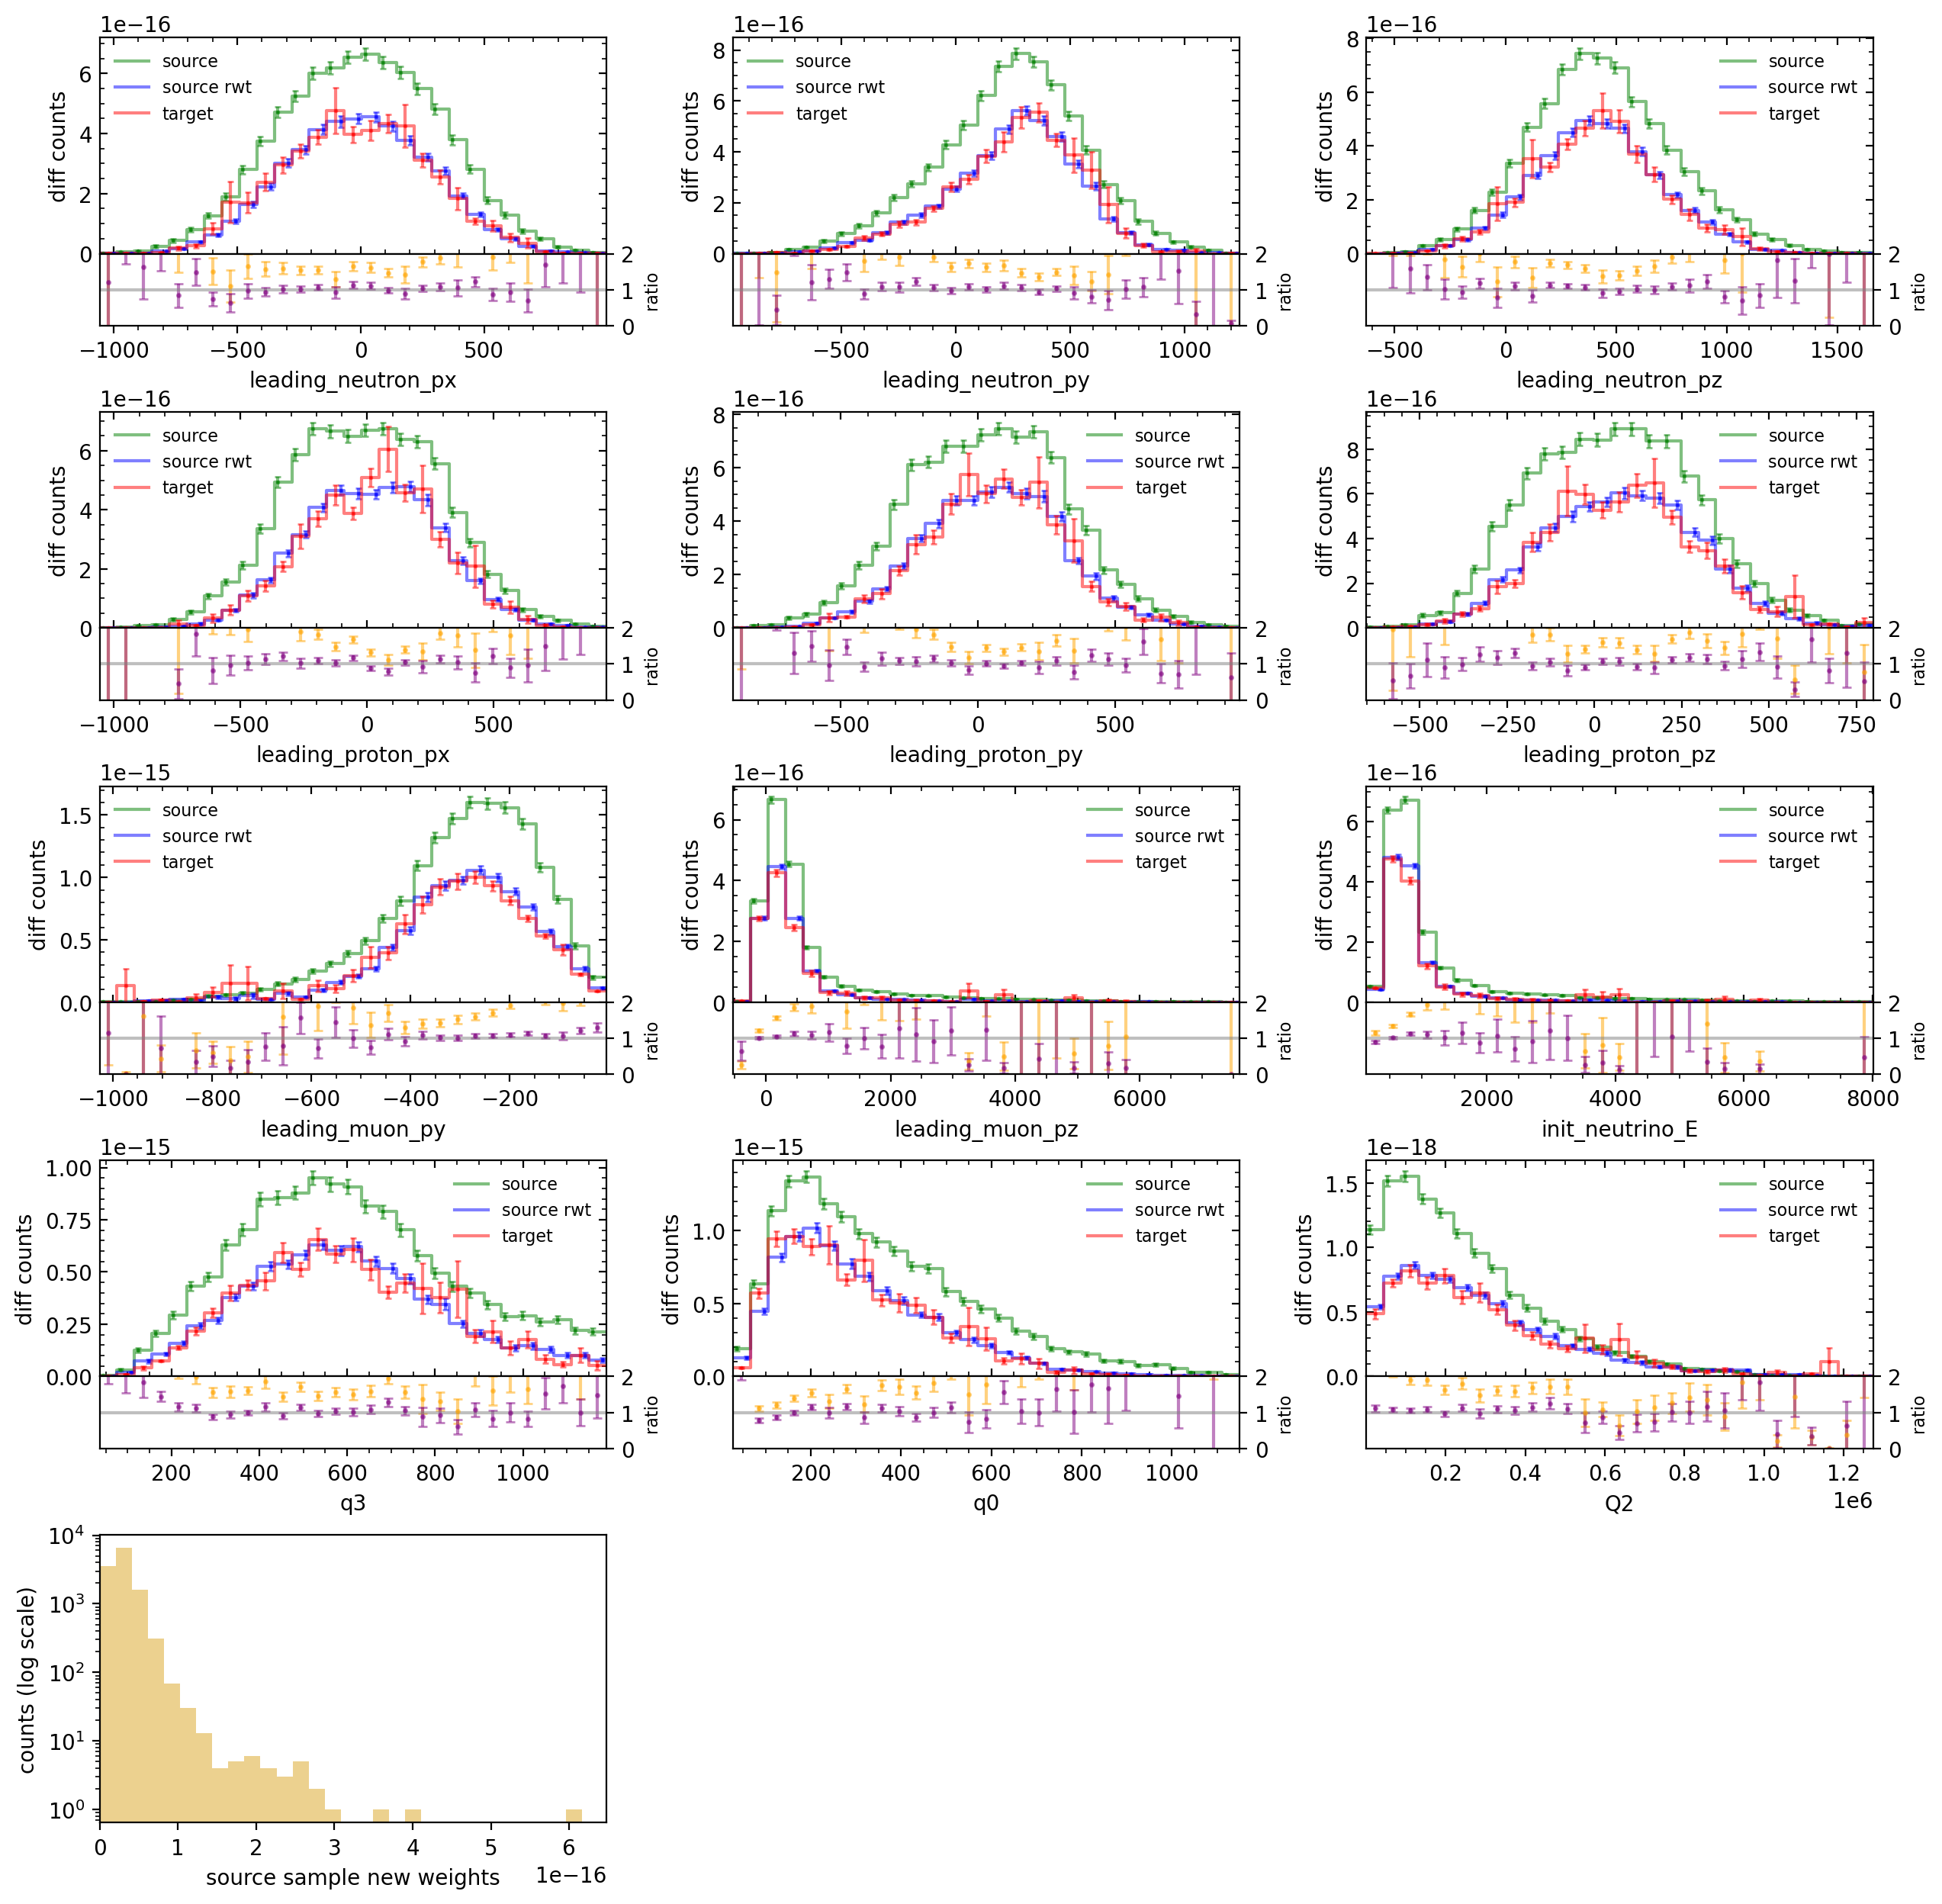

In [9]:
# predict weights and plot
oldInclusive[category]['weight1'] = reweighter.predict_matched_total_weights(oldInclusive[category][reweight_variables], 
            original_weight=oldInclusive[category]['weight0'],
            target_weight=newInclusive[category][weight_channel]
)
oldInclusive[category]['weight'] = oldInclusive[category]['weight1']


drawing_variables=[
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    'init_neutrino_E',
    'q3', 'q0','Q2',
    'weight',
]

mask = oldInclusive[category]['weight1']>=0
draw_source_target_distributions_and_ratio(oldInclusive[category].loc[mask], newInclusive[category], variables=drawing_variables,
    source_weights=oldInclusive[category].loc[mask]['weight0'], 
    new_source_weights=oldInclusive[category].loc[mask]['weight1'], 
    target_weights=newInclusive[category][weight_channel]
)

## Step 3: Reweight from new Valencia inclusive to new Valencia exclusive
### 2p2h pp channel:

In [10]:
# prepare dataframes and reweight training

category = 'pp'
weight_channel = 'weight_pp'

# reweight to new inclusive first:
# train reweighter
reweight_variables = [
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    # 'init_neutrino_E'
]

reweighter = Reweighter(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, gb_args={'subsample': 1.0})
reweighter.fit(oldInclusive[category][reweight_variables], newExclusive[category][reweight_variables],
            original_weight=oldInclusive[category]['weight1'],
            target_weight=newExclusive[category][weight_channel]
)
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_newInclusive_to_newExclusive_{category}.pkl')
# # load from saved
# reweighter = Reweighter.load_from_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_newInclusive_to_newExclusive_{category}.pkl')



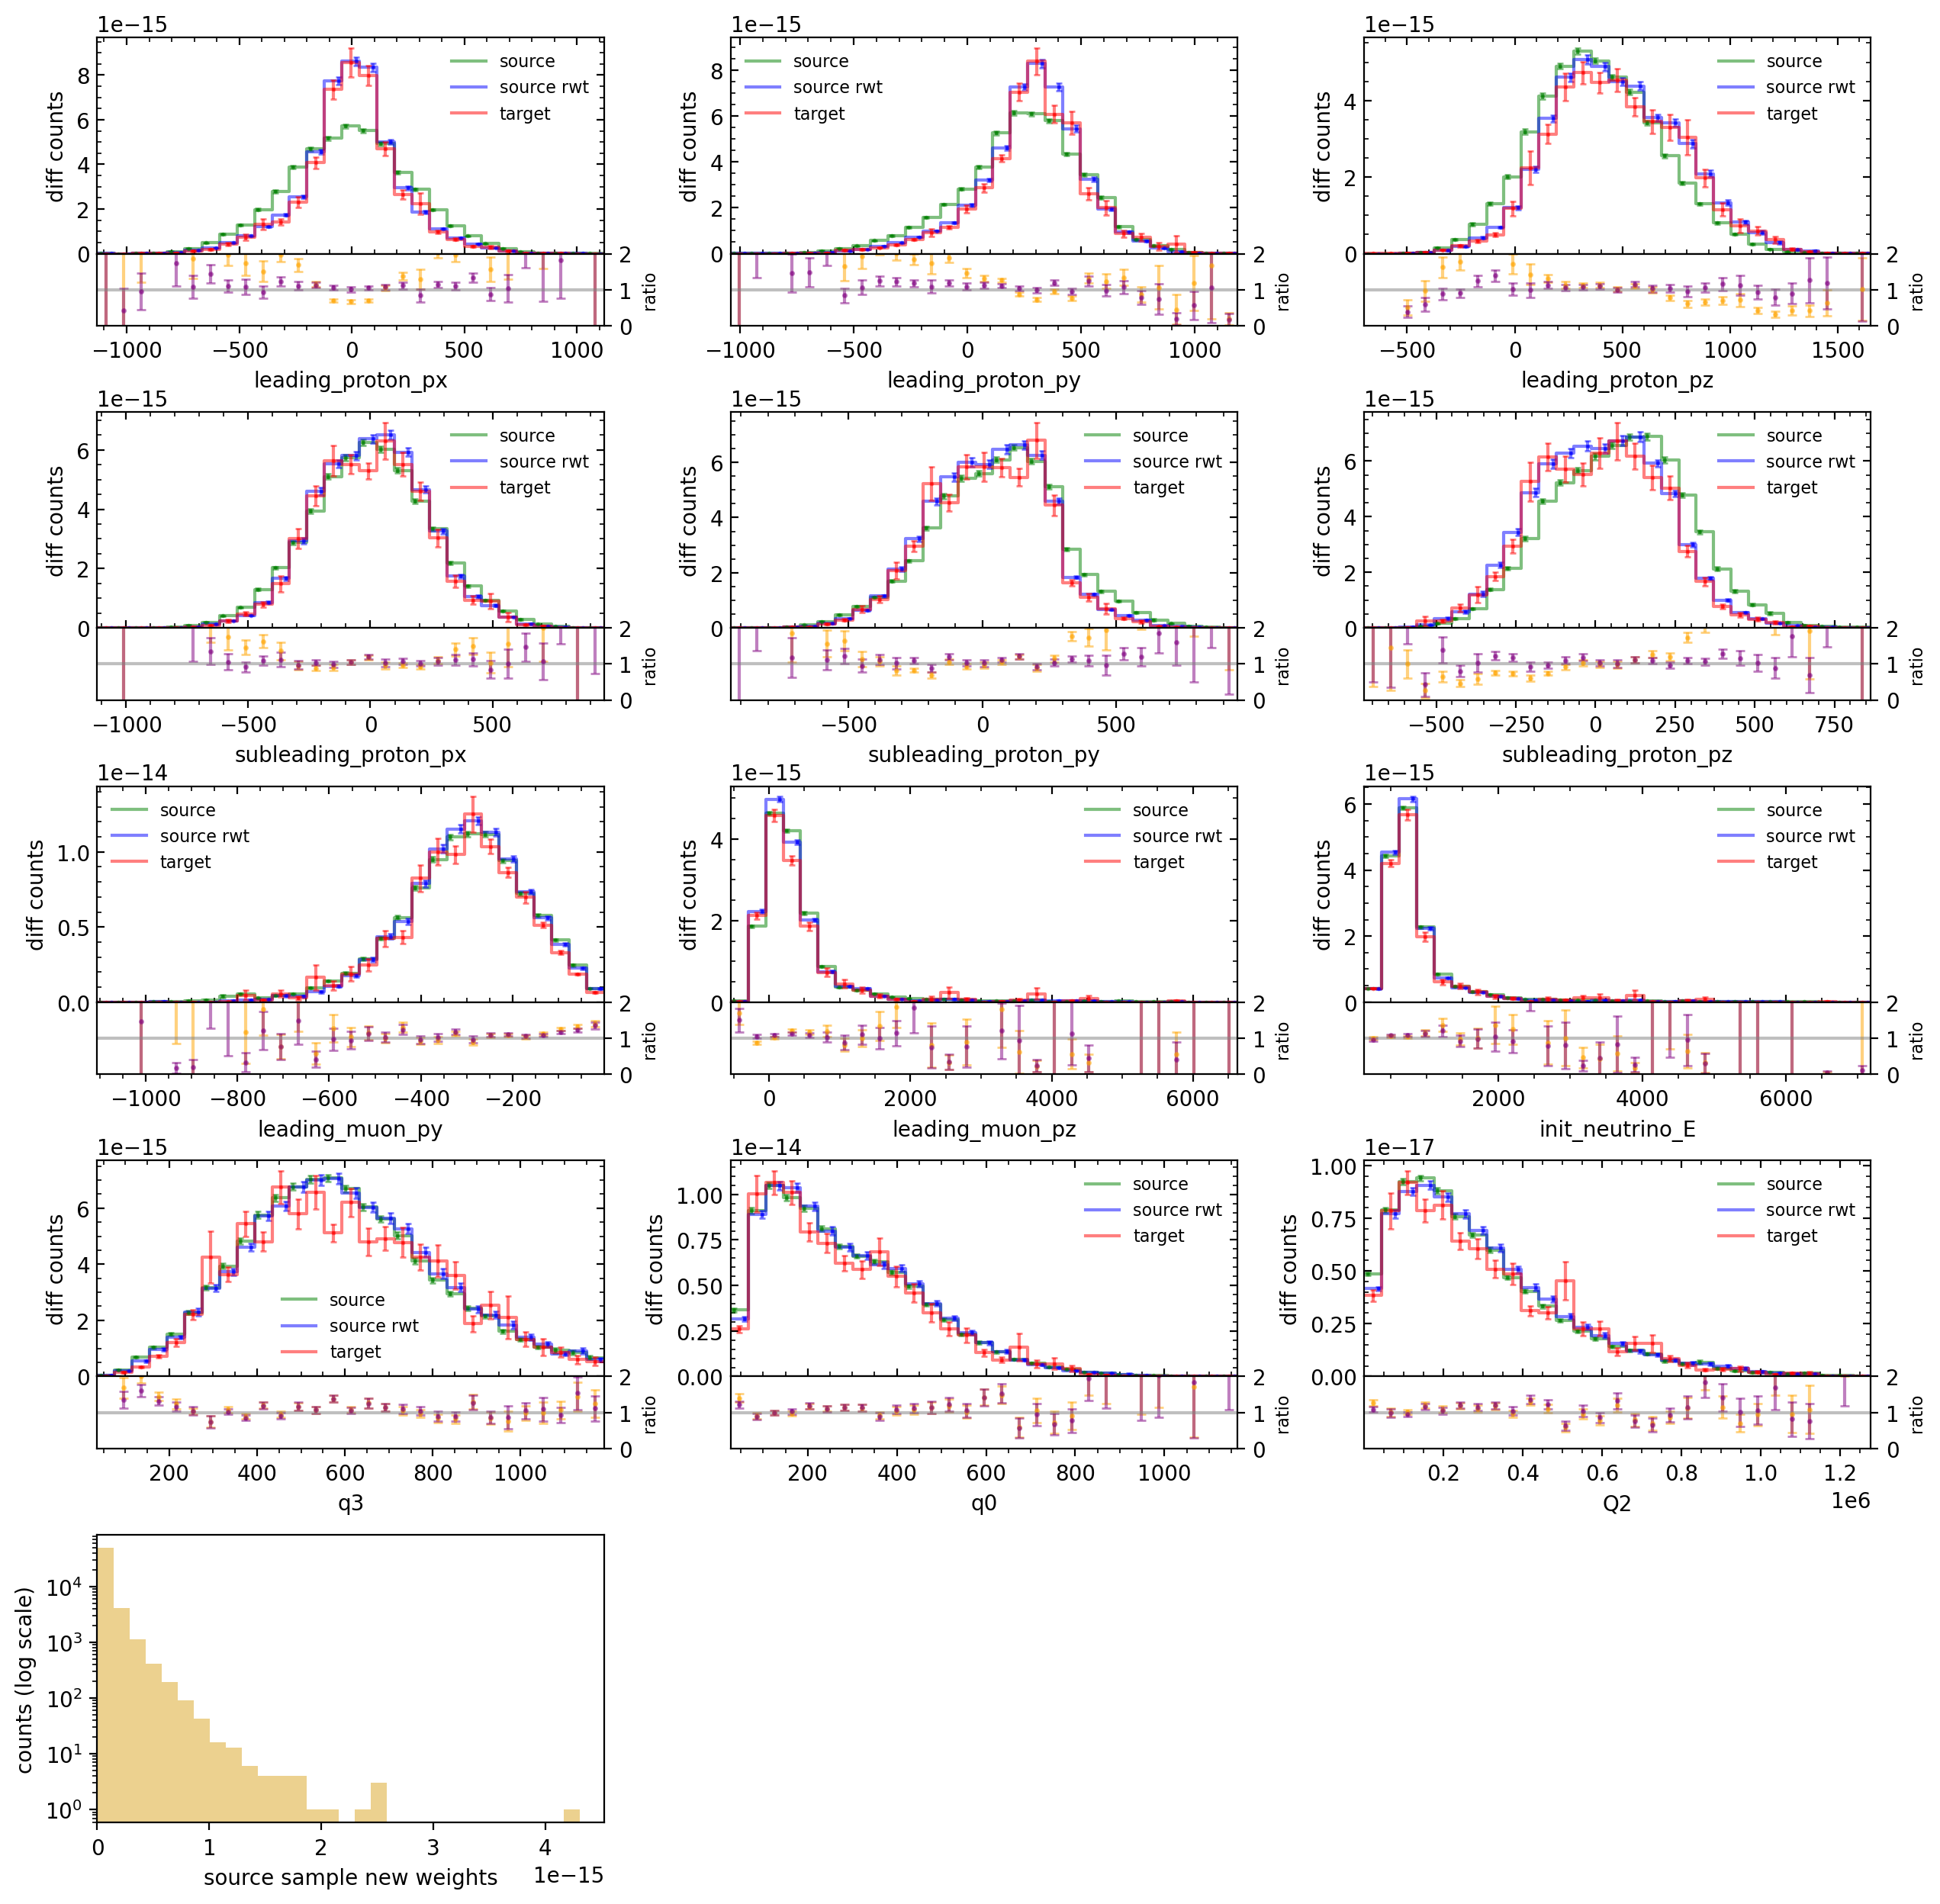

In [11]:
# predict weights and plot
oldInclusive[category]['weight2'] = reweighter.predict_matched_total_weights(oldInclusive[category][reweight_variables], 
            original_weight=oldInclusive[category]['weight1'],
            target_weight=newInclusive[category][weight_channel]
)
oldInclusive[category]['weight'] = oldInclusive[category]['weight2']

drawing_variables=[
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    'init_neutrino_E',
    'q3', 'q0','Q2',
    'weight',
]

mask = oldInclusive[category]['weight2']>=0
draw_source_target_distributions_and_ratio(oldInclusive[category].loc[mask], newExclusive[category], variables=drawing_variables,
    source_weights=oldInclusive[category].loc[mask]['weight1'], 
    new_source_weights=oldInclusive[category].loc[mask]['weight2'], 
    target_weights=newExclusive[category][weight_channel]
)

### 2p2h pn channel:

In [12]:
# prepare dataframes and reweight training

category = 'pn'
weight_channel = 'weight_pn'

# reweight to new inclusive first:
# train reweighter
reweight_variables = [
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_muon_py', 'leading_muon_pz',
    # 'init_neutrino_E'
]

reweighter = Reweighter(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, gb_args={'subsample': 1.0})
reweighter.fit(oldInclusive[category][reweight_variables], newExclusive[category][reweight_variables],
            original_weight=oldInclusive[category]['weight1'],
            target_weight=newExclusive[category][weight_channel]
)
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_newInclusive_to_newExclusive_{category}.pkl')
# # load from saved
# reweighter = Reweighter.load_from_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_newInclusive_to_newExclusive_{category}.pkl')



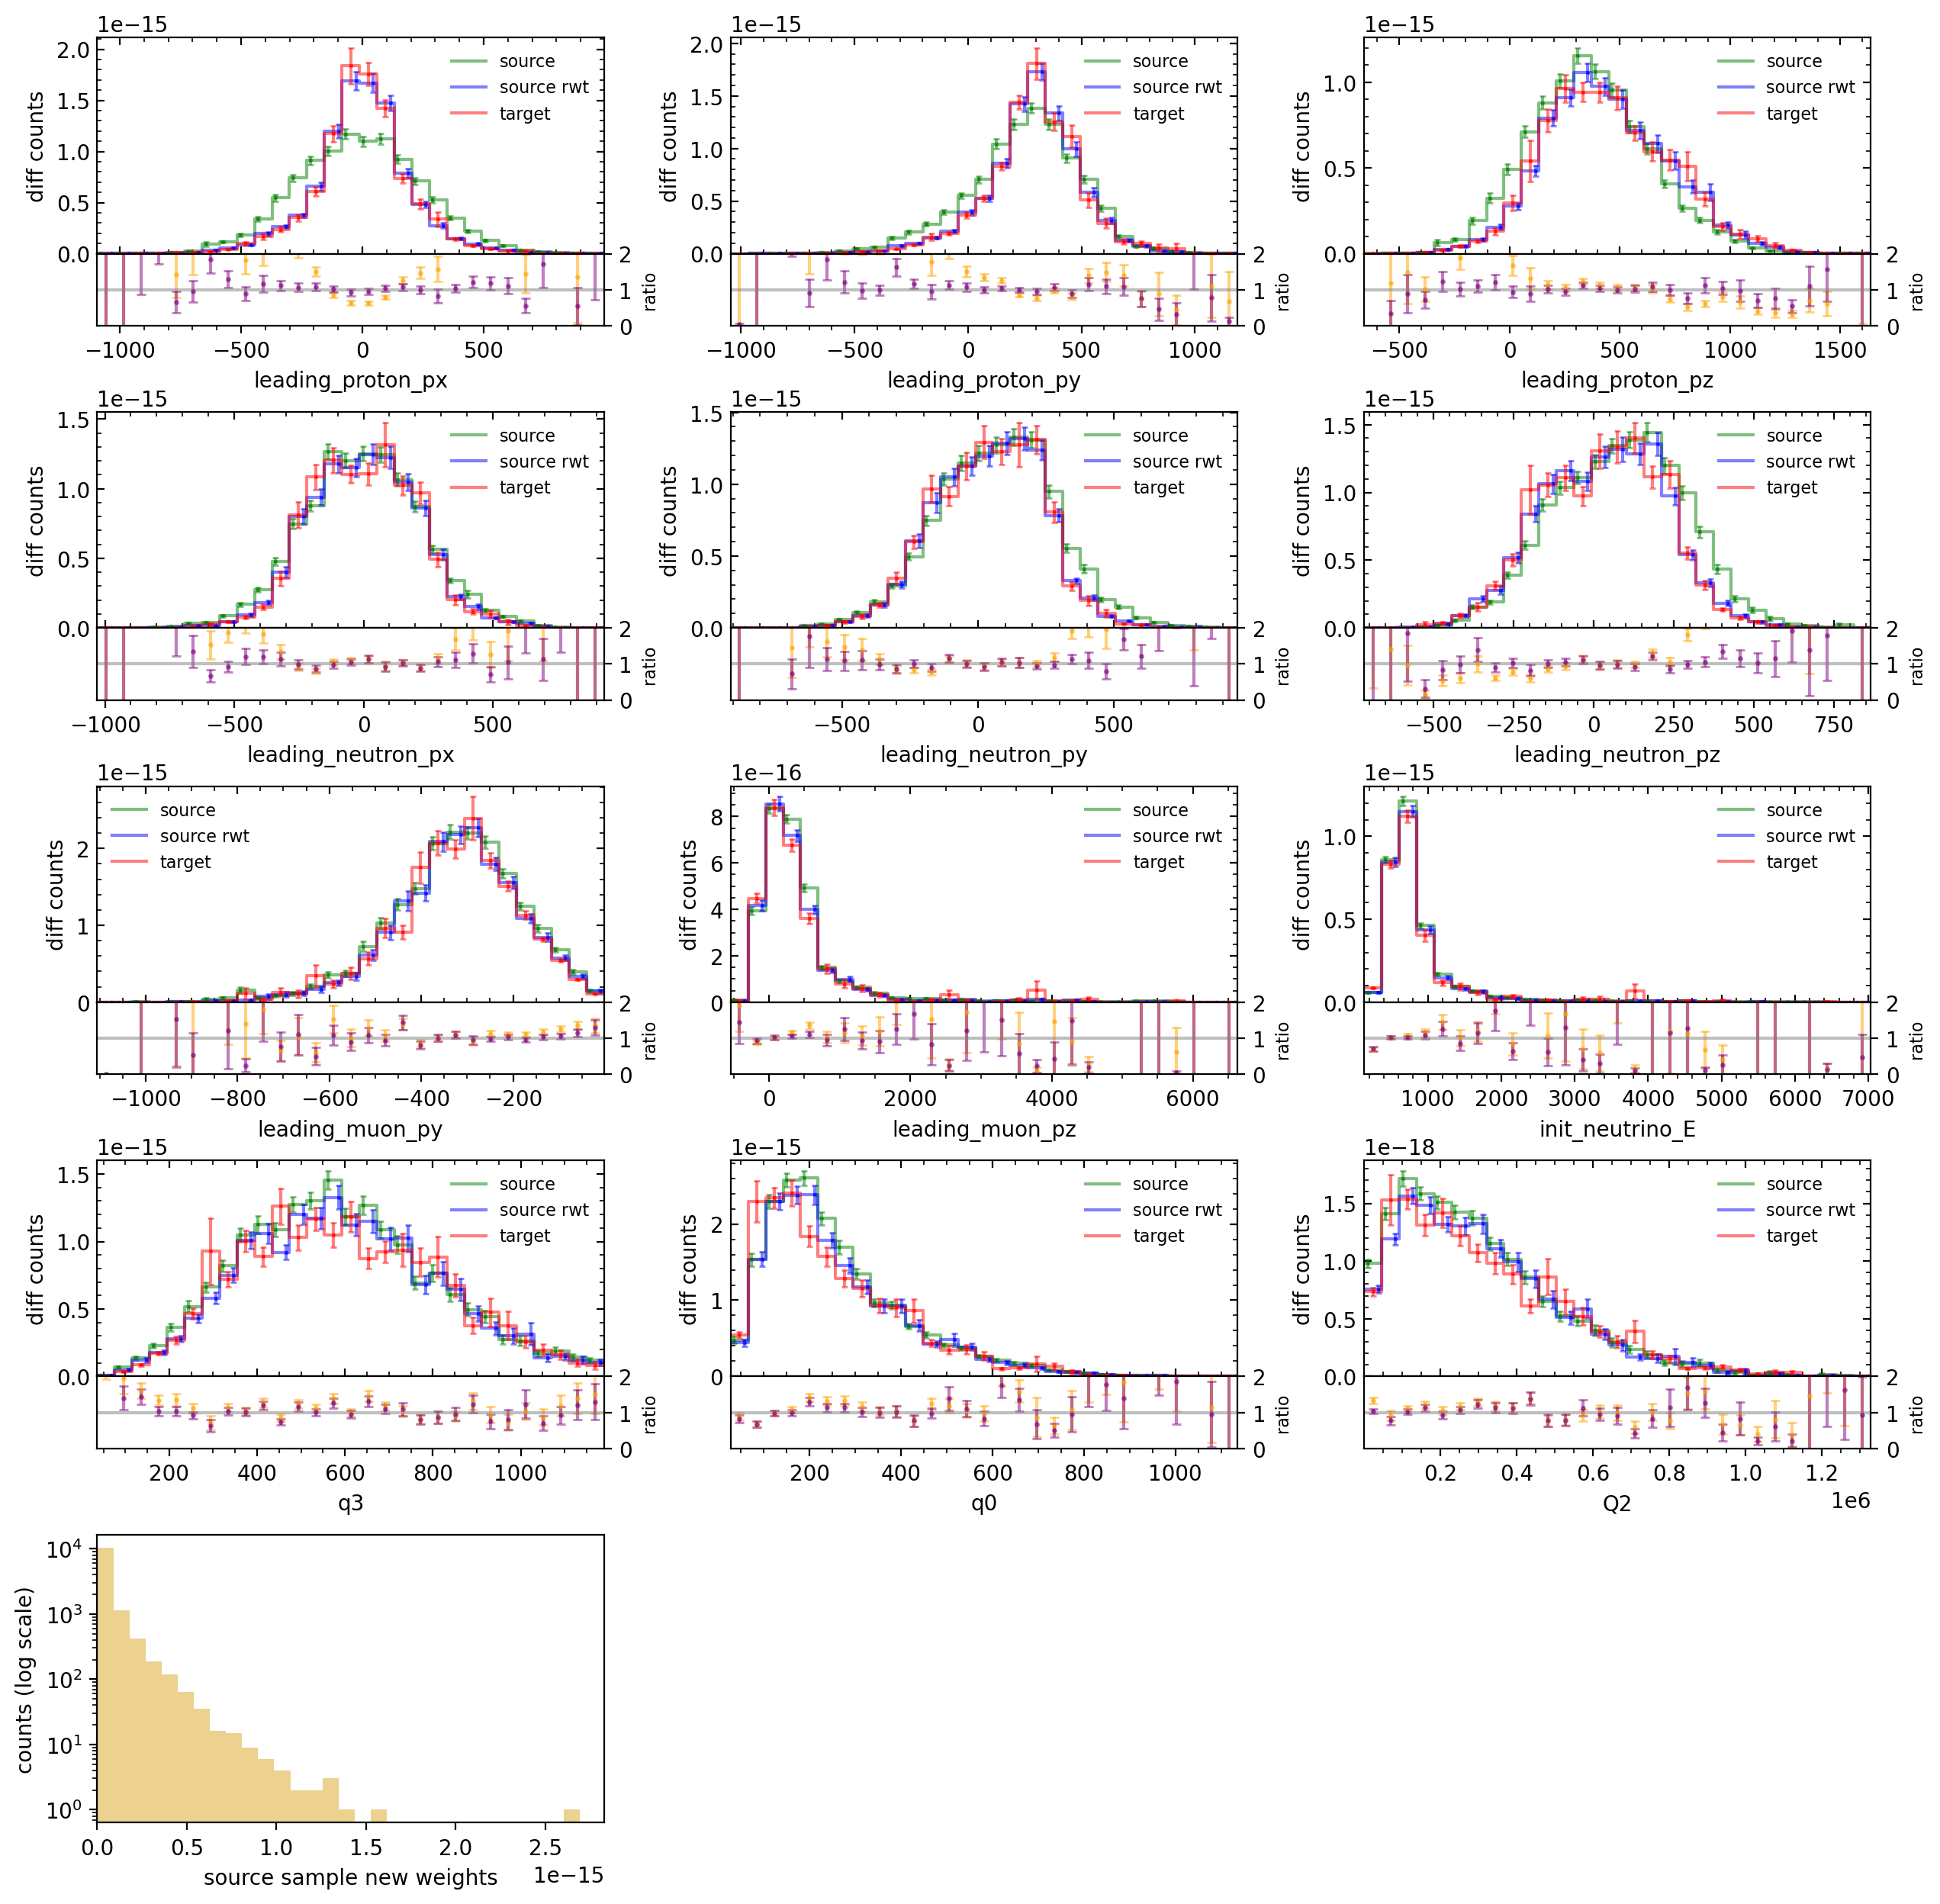

In [13]:
# predict weights and plot
oldInclusive[category]['weight2'] = reweighter.predict_matched_total_weights(oldInclusive[category][reweight_variables], 
            original_weight=oldInclusive[category]['weight1'],
            target_weight=newExclusive[category][weight_channel]
)
oldInclusive[category]['weight'] = oldInclusive[category]['weight2']

drawing_variables=[
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_muon_py', 'leading_muon_pz',
    'init_neutrino_E',
    'q3', 'q0','Q2',
    'weight',
]

mask = oldInclusive[category]['weight2']>=0
draw_source_target_distributions_and_ratio(oldInclusive[category].loc[mask], newExclusive[category], variables=drawing_variables,
    source_weights=oldInclusive[category].loc[mask]['weight1'], 
    new_source_weights=oldInclusive[category].loc[mask]['weight2'], 
    target_weights=newExclusive[category][weight_channel]
)

### 2p2h np channel:

In [14]:
# prepare dataframes and reweight training

category = 'np'
weight_channel = 'weight_np'

# reweight to new inclusive first:
# train reweighter
reweight_variables = [
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    # 'init_neutrino_E'
]

reweighter = Reweighter(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, gb_args={'subsample': 1.0})
reweighter.fit(oldInclusive[category][reweight_variables], newExclusive[category][reweight_variables],
            original_weight=oldInclusive[category]['weight1'],
            target_weight=newExclusive[category][weight_channel]
)
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_newInclusive_to_newExclusive_{category}.pkl')
# # load from saved
# reweighter = Reweighter.load_from_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_T2K_flux_Valencia_2p2h_newInclusive_to_newExclusive_{category}.pkl')



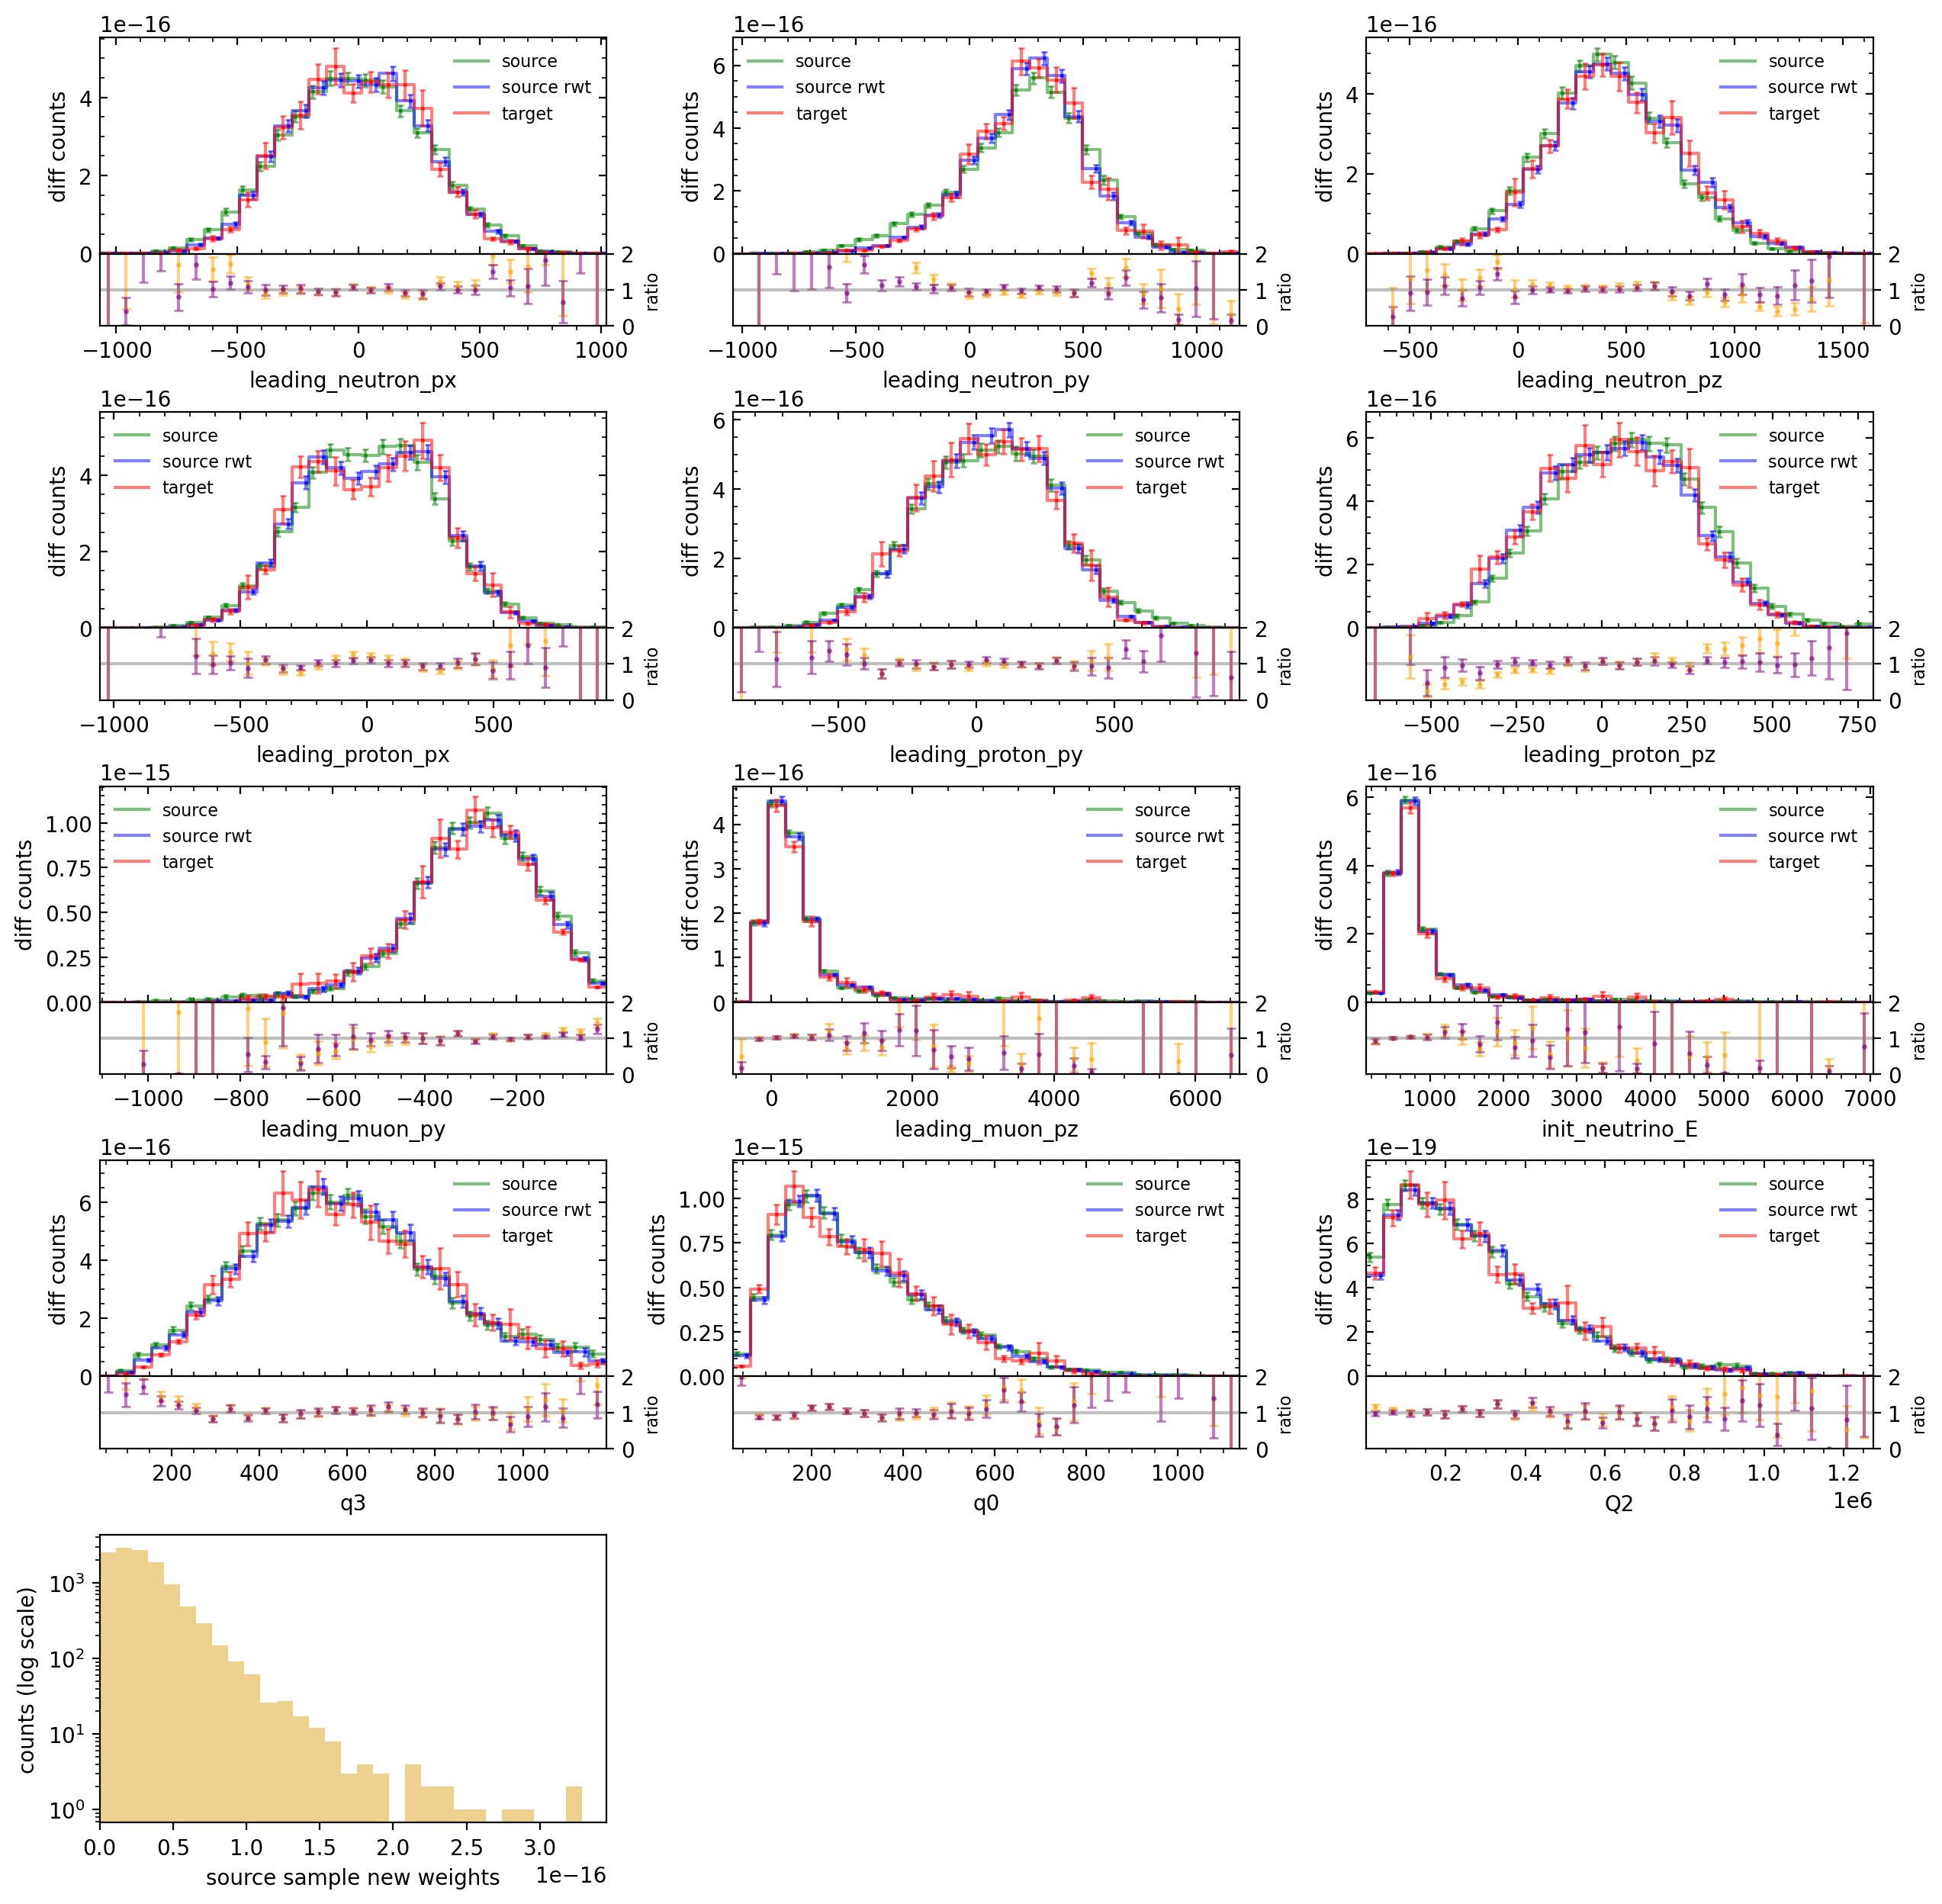

In [15]:
# predict weights and plot
oldInclusive[category]['weight2'] = reweighter.predict_matched_total_weights(oldInclusive[category][reweight_variables], 
            original_weight=oldInclusive[category]['weight1'],
            target_weight=newExclusive[category][weight_channel]
)
oldInclusive[category]['weight'] = oldInclusive[category]['weight2']

drawing_variables=[
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    'init_neutrino_E',
    'q3', 'q0','Q2',
    'weight',
]

mask = oldInclusive[category]['weight2']>=0
draw_source_target_distributions_and_ratio(oldInclusive[category].loc[mask], newExclusive[category], variables=drawing_variables,
    source_weights=oldInclusive[category].loc[mask]['weight1'], 
    new_source_weights=oldInclusive[category].loc[mask]['weight2'], 
    target_weights=newExclusive[category][weight_channel]
)